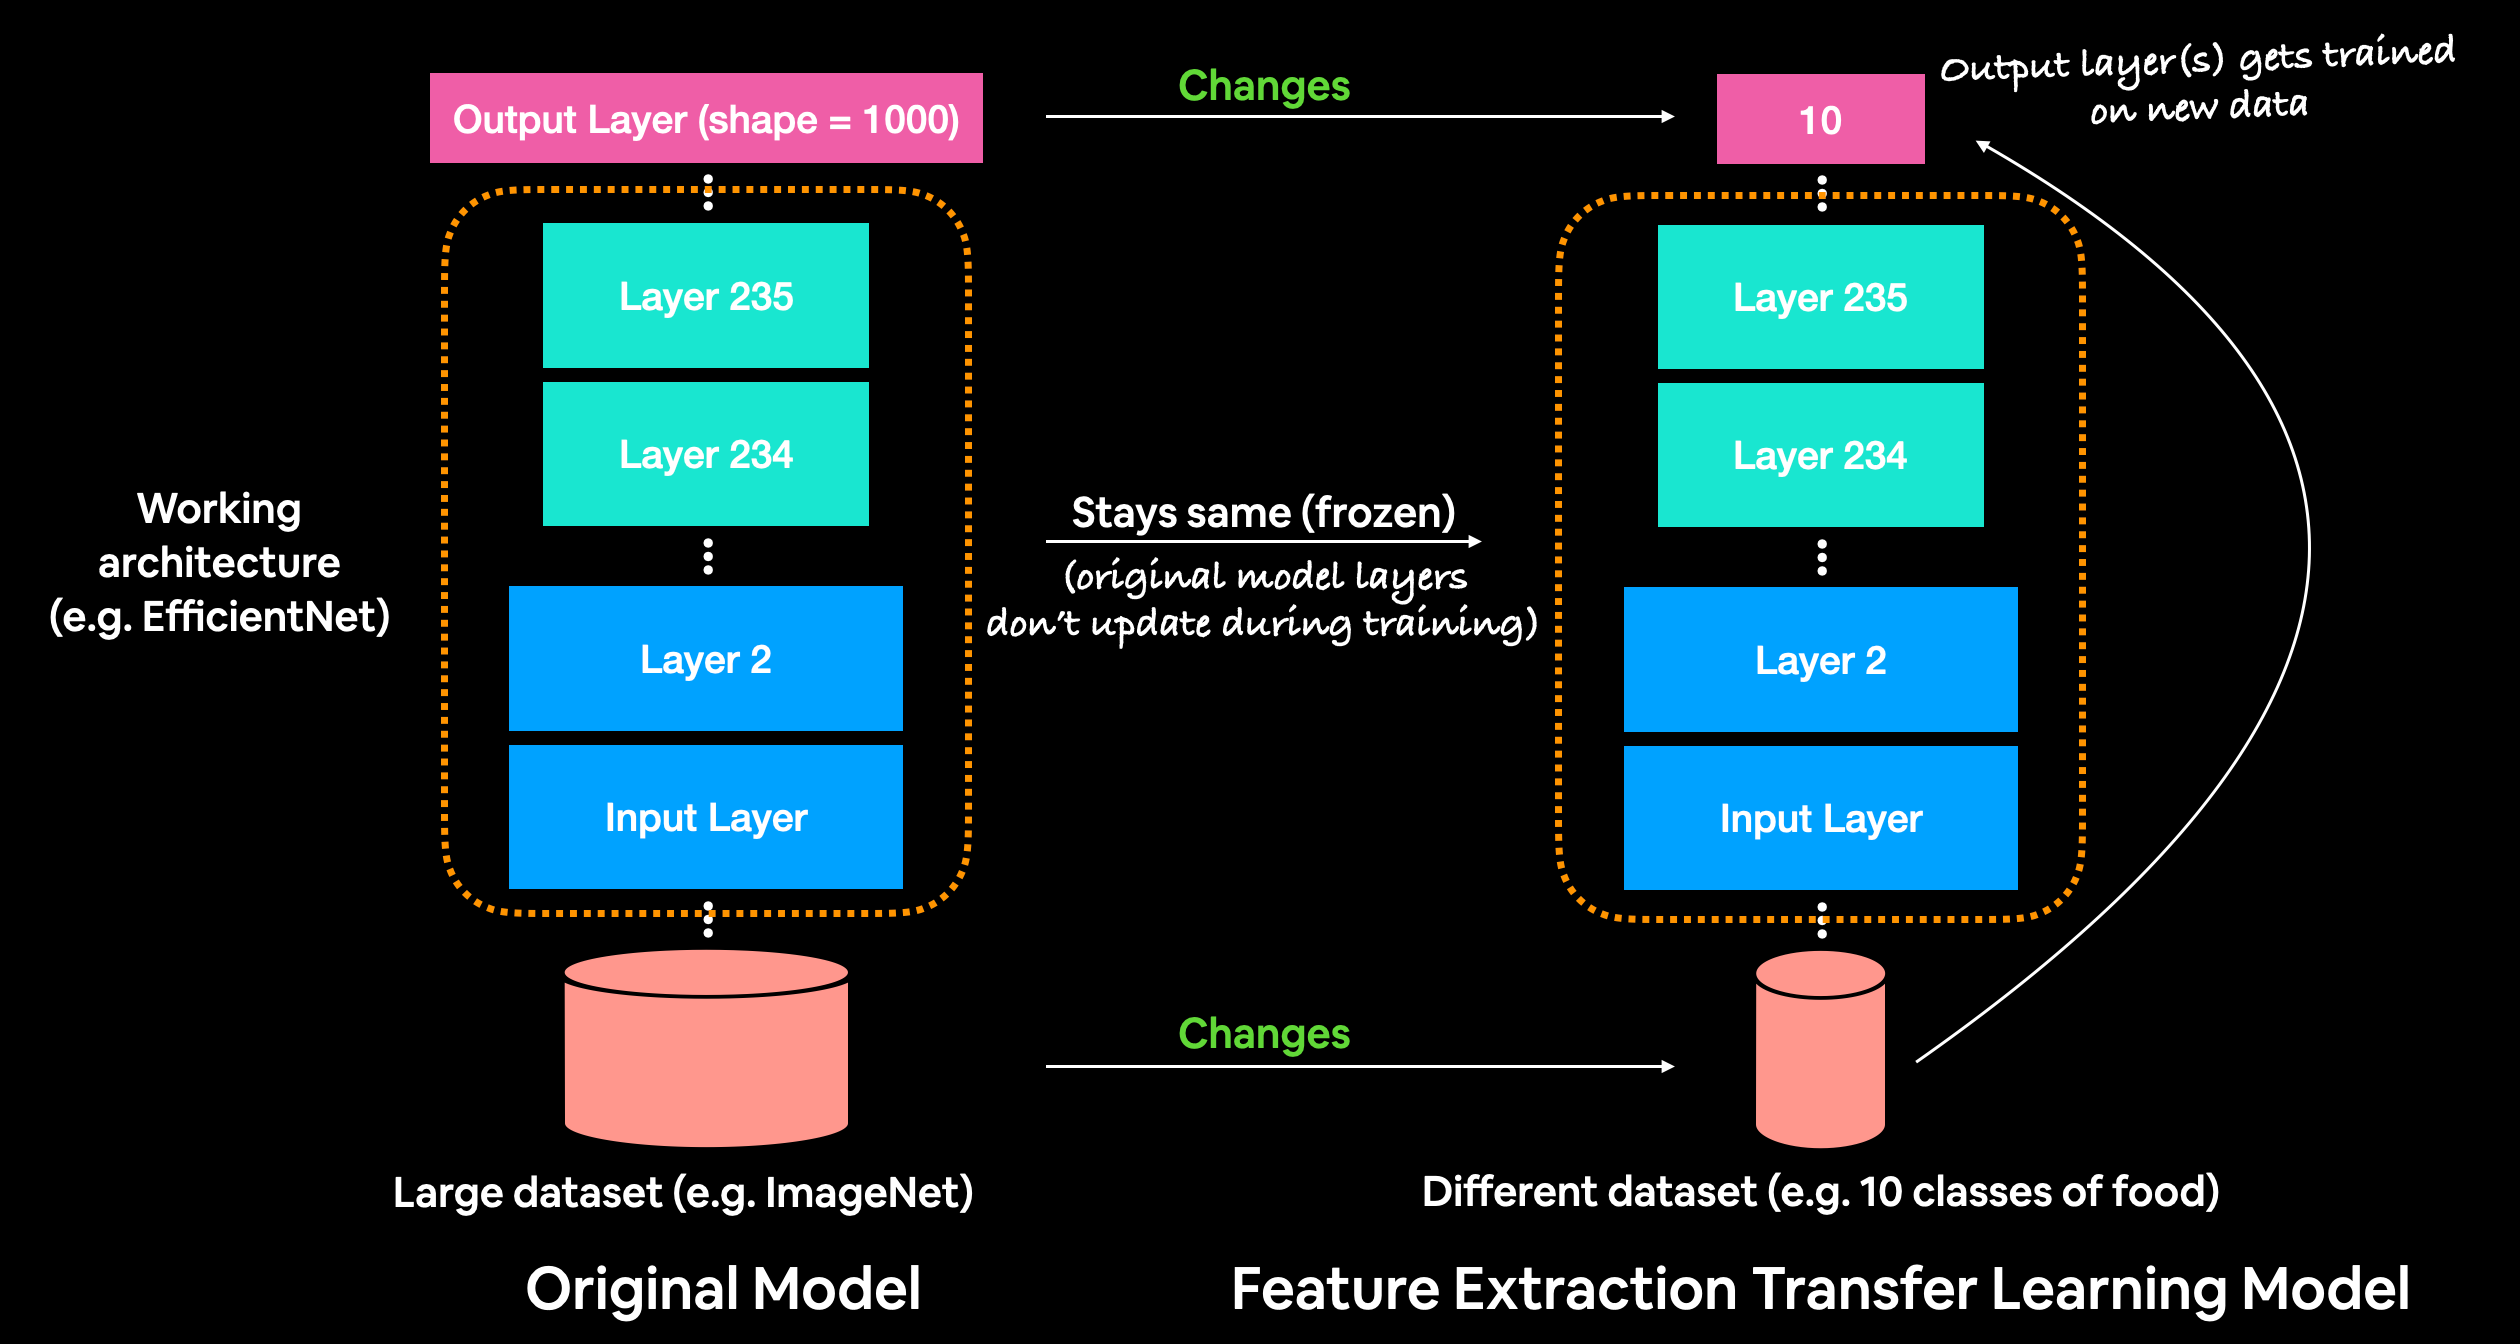


# Downloading and becoming one with the data

In [1]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-08-21 14:17:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  95.8MB/s    in 1.7s    

2021-08-21 14:17:50 (95.8 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

# Creating Data Loaders(preparing the data)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


# Setting up callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training
* tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [4]:
 import datetime

 def create_tensorboard_callback(dir_name, experiment_name):
   log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
   tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
   print(f"Saving TensorBoard log files to: {log_dir}")
   return tensorboard_callback

# Creating models using tensorflow hub

In [5]:
# compare two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
def create_model(m_url, num_classes=10):
  feauture_extractor_layer = hub.KerasLayer(m_url,
                                            trainable=False, #freeze the already learned patterns
                                            name="F_extraction",
                                            input_shape=IMAGE_SHAPE+(3,))
  
  #create sequential
  model = tf.keras.Sequential([
    feauture_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

Creating and testing ResNet TF Hub model

In [8]:
resnet_model = create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
F_extraction (KerasLayer)    (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2"
                                                                         )])



Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210821 - 141759
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8896 - accuracy: 0.3680 - val_loss: 1.1794 - val_accuracy: 0.6224
Epoch 2/5
24/24 [==============================] - 21s 901ms/step - loss: 0.8733 - accuracy: 0.7440 - val_loss: 0.8515 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 21s 907ms/step - loss: 0.6252 - accuracy: 0.8160 - val_loss: 0.7606 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.4689 - accuracy: 0.8920 - val_loss: 0.7042 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 21s 908ms/step - loss: 0.3732 - accuracy: 0.9187 - val_loss: 0.6640 - val_accuracy: 0.7824


In [12]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 16s 205ms/step - loss: 0.6640 - accuracy: 0.7824


[0.6639674305915833, 0.7824000120162964]

# Plotting the results

In [13]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

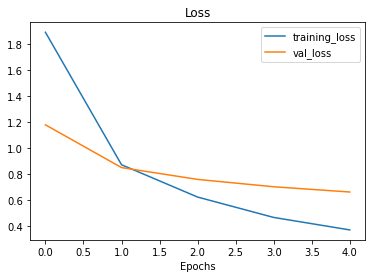

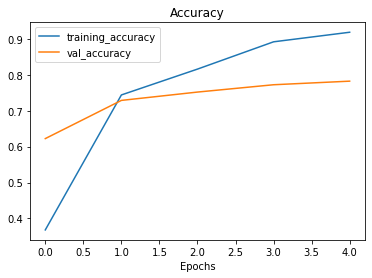

In [14]:
plot_loss_curves(history_resnet)

# Creating and testing the EfficientNet Model

In [16]:
efficientnet_model = create_model(m_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210821 - 142653
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8538 - accuracy: 0.4627 - val_loss: 1.3239 - val_accuracy: 0.7372
Epoch 2/5
24/24 [==============================] - 19s 835ms/step - loss: 1.0653 - accuracy: 0.7987 - val_loss: 0.8750 - val_accuracy: 0.8248
Epoch 3/5
24/24 [==============================] - 19s 833ms/step - loss: 0.7522 - accuracy: 0.8440 - val_loss: 0.7052 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 19s 831ms/step - loss: 0.6052 - accuracy: 0.8693 - val_loss: 0.6138 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 20s 836ms/step - loss: 0.5112 - accuracy: 0.8907 - val_loss: 0.5611 - val_accuracy: 0.8644


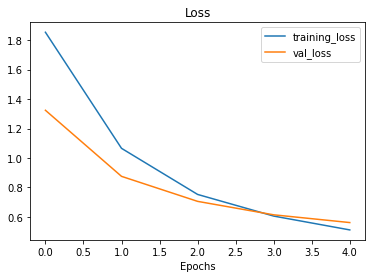

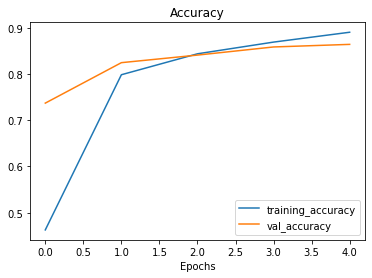

In [17]:


plot_loss_curves(efficientnet_history)

